In [1]:
import numpy as np
import os
import cv2
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import zipfile
from PIL import Image
import io
import numpy as np

# Adult dataset

### Extracting Features

Mounted at /content/drive
Loaded 750 images with labels: {0, 1}
Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.0163 - val_loss: 0.0050
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 8.8900e-04 - val_loss: 4.7159e-04
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 5.7114e-04 - val_loss: 4.4459e-04
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 4.8084e-04 - val_loss: 2.8165e-04
Epoch 9/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 3.8522e-04 - val_loss: 2.9596e-04
Epoch 10/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 2.6431e-04 - val_loss: 3.1299e-04
Epoch 11/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49

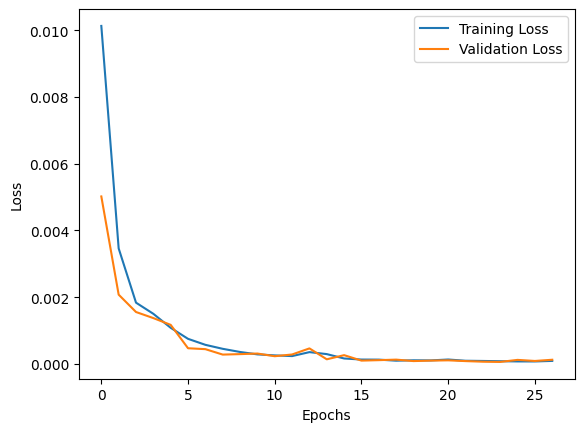

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
Extracted features shape: (750, 100352)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
from PIL import Image
import io


def load_images_and_labels_from_zip(zip_path):
    images = []
    labels = []

    with zipfile.ZipFile(zip_path, 'r') as zipf:
        for filename in zipf.namelist():
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                # Extract label from filename (prefix before first underscore)
                label = int(filename.split('_')[0])
                labels.append(label)

                # Read image from zip
                with zipf.open(filename) as img_file:
                      img = Image.open(io.BytesIO(img_file.read())).convert('RGB')
                      img = img.resize((224, 224))
                      img_array = np.array(img) / 255.0
                      images.append(img_array)

    return np.array(images), labels

images, labels = load_images_and_labels_from_zip('/content/drive/MyDrive/clustered_images.zip')
print(f"Loaded {len(images)} images with labels: {set(labels)}")


X_train, X_val = train_test_split(images, test_size=0.2, random_state=42)

# 2. Build the autoencoder model
def build_autoencoder(input_shape=(224, 224, 3)):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Full autoencoder
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Encoder only (for feature extraction)
    encoder = Model(input_img, encoded)

    return autoencoder, encoder

autoencoder, encoder = build_autoencoder()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=30,
    batch_size=15,
    shuffle=True,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping]
    )

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Extract features using the encoder
def extract_features(encoder, images):
    features = encoder.predict(images)
    # Flatten the features to 1D vector per image
    features_flat = features.reshape((features.shape[0], -1))
    return features_flat

# Extract features for  images
all_features = extract_features(encoder, images)

print(f"Extracted features shape: {all_features.shape}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


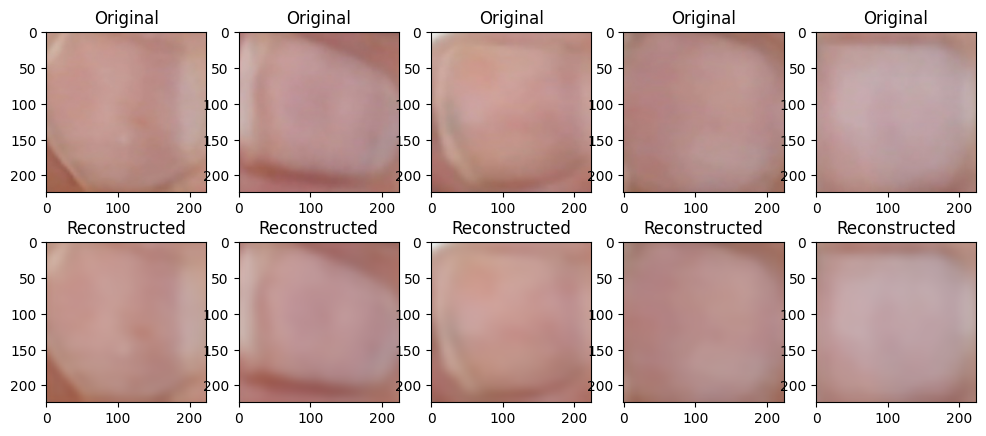

In [3]:
# Visualize some reconstructions
decoded_imgs = autoencoder.predict(X_val[:5])

plt.figure(figsize=(12,5))
for i in range(5):
    # Original
    plt.subplot(2,5,i+1)
    plt.title("Original")
    plt.imshow(X_val[i])
    # Reconstruction
    plt.subplot(2,5,i+6)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i])
plt.show()

### Training the model

#### SVM

In [4]:
X_train, x_val, y_train, y_val = train_test_split(all_features, labels, test_size = 0.2, random_state = 42)

In [5]:
from sklearn.svm import SVC

svm = SVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',
    random_state=42,
    probability=True,
    class_weight='balanced'
)

svm.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True, random_state=42)

In [6]:
y_pred = svm.predict(x_val)

print("Classification Report:")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.51      0.58        96
           1       0.39      0.56      0.46        54

    accuracy                           0.53       150
   macro avg       0.53      0.53      0.52       150
weighted avg       0.57      0.53      0.54       150

Confusion Matrix:
[[49 47]
 [24 30]]


#### RandomForest

In [7]:
rf = RandomForestClassifier(
    bootstrap = True,
    max_depth = 20,
    min_samples_split = 5,
    min_samples_leaf = 4,
    n_estimators = 500,
    max_features = 'sqrt',
    random_state = 42
    )

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=500, random_state=42)

In [8]:
y_pred = rf.predict(x_val)

print("Classification Report:")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.80      0.70        96
           1       0.27      0.13      0.17        54

    accuracy                           0.56       150
   macro avg       0.45      0.47      0.44       150
weighted avg       0.49      0.56      0.51       150

Confusion Matrix:
[[77 19]
 [47  7]]


# children dataset

### Loading dataset

In [9]:
def load_images_and_labels_from_zip(zip_path):
    images = []
    labels = []

    with zipfile.ZipFile(zip_path, 'r') as zipf:
        for filename in zipf.namelist():
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                # Determine the label
                label = 1 if 'non_anemic' in filename.lower() else 0

                # Read and preprocess image
                with zipf.open(filename) as img_file:
                    img = Image.open(io.BytesIO(img_file.read())).convert('RGB')
                    img = img.resize((224, 224))
                    img_array = np.array(img) / 255.0
                    images.append(img_array)
                    labels.append(label)

    return np.array(images), labels

images, labels = load_images_and_labels_from_zip('/content/drive/MyDrive/selected_fingernails.zip')
print(f"Loaded {len(images)} images with labels: {set(labels)}")


Loaded 750 images with labels: {0, 1}


### Extrcting Features

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.0631 - val_loss: 0.0082
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0068 - val_loss: 0.0041
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0013 - val_loss: 9.3549e-04
Epoch 9/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0011 - val_loss: 9.2665e-04
Epoch 11/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 9.9129e-04 - val_loss: 9.5188e-04
Epoch 12/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/

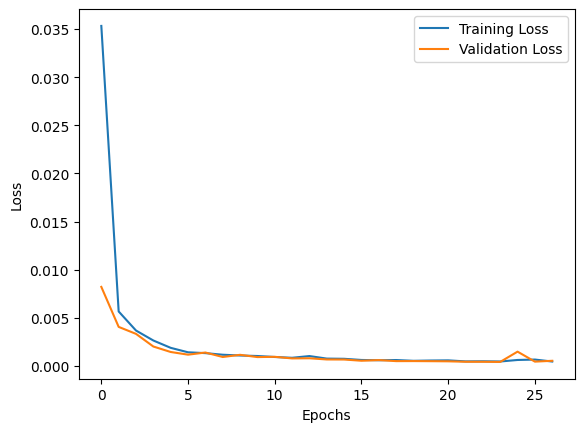

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Extracted features shape: (750, 100352)


In [10]:
# Split into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(images, test_size=0.2, random_state=42)

autoencoder_kids, encoder_kids = build_autoencoder()

# Train the autoencoder
history_kids = autoencoder_kids.fit(
    X_train, X_train,
    epochs=30,
    batch_size=15,
    shuffle=True,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping]
)

# Plot training history
plt.plot(history_kids.history['loss'], label='Training Loss')
plt.plot(history_kids.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Extract features using the encoder
def extract_features(encoder_kids, images):
    features = encoder_kids.predict(images)
    # Flatten the features to 1D vector per image
    features_flat = features.reshape((features.shape[0], -1))
    return features_flat

# Extract features for  images
all_features_kids = extract_features(encoder, images)

print(f"Extracted features shape: {all_features_kids.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


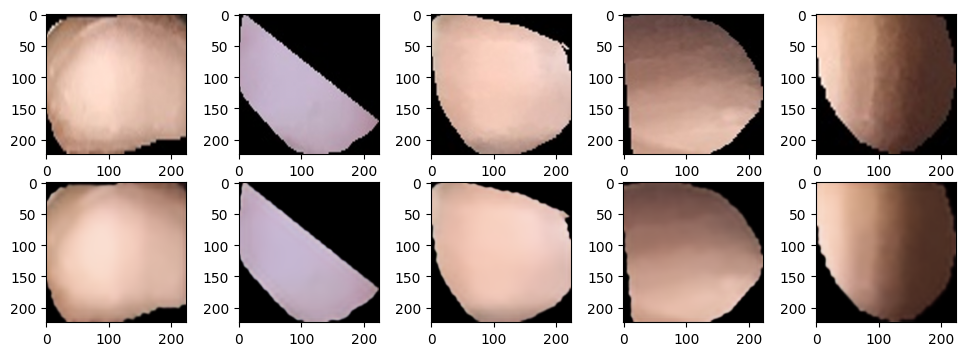

In [11]:
# Visualize some reconstructions
decoded_imgs_kids = autoencoder_kids.predict(X_val[:5])

plt.figure(figsize=(12,4))
for i in range(5):
    # Original
    plt.subplot(2,5,i+1)
    plt.imshow(X_val[i])
    # Reconstruction
    plt.subplot(2,5,i+6)
    plt.imshow(decoded_imgs_kids[i])
plt.show()

### Training the model

#### SVM

In [12]:
X_train, x_val, y_train, y_val = train_test_split(all_features_kids, labels, test_size = 0.2, random_state = 42)

svm = SVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',
    random_state=42,
    probability=True,
    class_weight='balanced'
)

svm.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True, random_state=42)

In [13]:
y_pred = svm.predict(x_val)

print("Classification Report:")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.74      0.67        72
           1       0.70      0.56      0.62        78

    accuracy                           0.65       150
   macro avg       0.65      0.65      0.65       150
weighted avg       0.66      0.65      0.64       150

Confusion Matrix:
[[53 19]
 [34 44]]


#### RandomForest

In [14]:
X_train, x_val, y_train, y_val = train_test_split(all_features_kids, labels, test_size = 0.2, random_state = 42)

rf = RandomForestClassifier(
    bootstrap = True,
    max_depth = 20,
    min_samples_split = 5,
    min_samples_leaf = 4,
    n_estimators = 500,
    max_features = 'sqrt',
    random_state = 42
    )

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=500, random_state=42)

In [15]:
y_pred = rf.predict(x_val)

print("Classification Report:")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78        72
           1       0.81      0.76      0.78        78

    accuracy                           0.78       150
   macro avg       0.78      0.78      0.78       150
weighted avg       0.78      0.78      0.78       150

Confusion Matrix:
[[58 14]
 [19 59]]


# Combined dataset

In [19]:
!unzip -n "/content/drive/MyDrive/features.zip"

Archive:  /content/drive/MyDrive/features.zip
   creating: features/
  inflating: features/train_labels.npy  
  inflating: features/val_labels.npy  
  inflating: features/train_features.npy  
  inflating: features/val_features.npy  


### Training the model

In [20]:
train_features = np.load('/content/features/train_features.npy')
y_train = np.load('/content/features/train_labels.npy')
val_features = np.load('/content/features/val_features.npy')
y_val = np.load('/content/features/val_labels.npy')

#### SVM

In [21]:
print("train_features shape:", train_features.shape)
print("y_train shape:", y_train.shape)

train_features shape: (1200, 100352)
y_train shape: (1200,)


In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_features)  # Normalizes features

In [23]:
from sklearn.svm import LinearSVC  # Recommended for high dimensions

svm = LinearSVC(
    C=1.0,
    penalty='l2',
    dual=False,
    random_state=42,
    class_weight='balanced'
)
svm.fit(X_scaled, y_train)

LinearSVC(class_weight='balanced', dual=False, random_state=42)

In [27]:
val_features_scaled = scaler.transform(val_features)
y_pred = svm.predict(val_features_scaled)

print("Classification Report:")
print(classification_report(y_val, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.63      0.62       166
           1       0.53      0.51      0.52       134

    accuracy                           0.58       300
   macro avg       0.57      0.57      0.57       300
weighted avg       0.58      0.58      0.58       300


Confusion Matrix:
[[104  62]
 [ 65  69]]


#### RandomForest

In [25]:
rf = RandomForestClassifier(
    bootstrap = True,
    max_depth = 20,
    min_samples_split = 5,
    min_samples_leaf = 4,
    n_estimators = 500,
    max_features = 'sqrt',
    random_state = 42
    )

rf.fit(train_features, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=500, random_state=42)

In [26]:
y_pred = rf.predict(val_features)

print("Classification Report:")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.84      0.74       166
           1       0.70      0.46      0.55       134

    accuracy                           0.67       300
   macro avg       0.68      0.65      0.65       300
weighted avg       0.68      0.67      0.66       300

Confusion Matrix:
[[140  26]
 [ 73  61]]
